# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum

test_func = func_overflow

#### Dimension and margins
We first define the problem dimension and the margins

In [3]:
if test_func == func_overflow:
    margins = margins_overflow
    dim = len(margins)
else:
    dim = 6
    margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

In [4]:
if test_func == func_sum:
    coeficients = np.logspace(0., 5., dim+1, endpoint=False)[1:]

    n_plot = 10000
    x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
    y = test_func(x, coeficients)

    fig, axes = plt.subplots(dim, 1, sharex=True, sharey=True, figsize=(4, 2*dim))
    for i in range(dim):
        ax = axes[i]
        ax.plot(x[:, i], y, '.')
        ax.set_xlabel(r'$X_%d$' % (i+1), fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)
    fig.tight_layout()

#### Copula families
We now consider only Gaussian dependencies for this example

In [5]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [6]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.95

if alpha > 0.5: # Maximizing the quantile
    def q_func(x, axis=1):
        return - quantile_func(alpha)(x, axis=axis)
else: # Minimizing
    q_func = quantile_func(alpha)

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

First, we compute the quantile at independence

In [7]:
n = 10000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)[0]

In [8]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: 4.86 with a C.O.V at 2.1 %


### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [39]:
from dependence import iterative_vine_minimize

algorithm_parameters = {
    "n_input_sample": 10000,
    "n_dep_param_init": None,
    "max_n_pairs": 4,
    "grid_type": 'vertices',
    "q_func": q_func,
    "n_add_pairs": 2,
    "n_remove_pairs": 0,
    "adapt_vine_structure": False,
    "with_bootstrap": False,
    "verbose": False,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False,
    "input_names": var_names_overflow
}

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)


Iteration 1: selected pair: (1, 0) (K_s-Q)
Total number of evaluations = 560000. Minimum quantity at 1.51.


Iteration 2: selected pair: (2, 1) (Z_v-K_s)
Total number of evaluations = 7320000. Minimum quantity at -0.03.



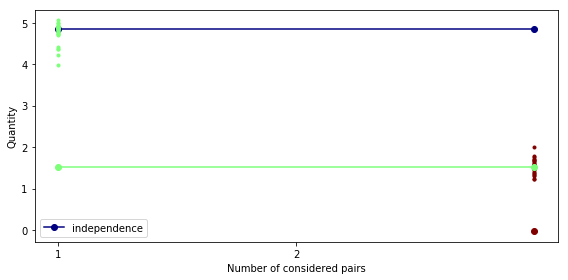

In [40]:
from dependence.dependence_plot import plot_iterative_results, matrix_plot_results

plot_iterative_results(iterative_results, indep_result=indep_result, q_func=q_func)

In [26]:
n = algorithm_parameters['n_input_sample']
K = 500
grid_results = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, q_func=q_func)

In [29]:
min_result = grid_results.min_result

In [36]:
min_result.compute_quantity_asymptotic_ci('quantile', alpha)

[-1.0849596748451371, -0.4214503018021557]

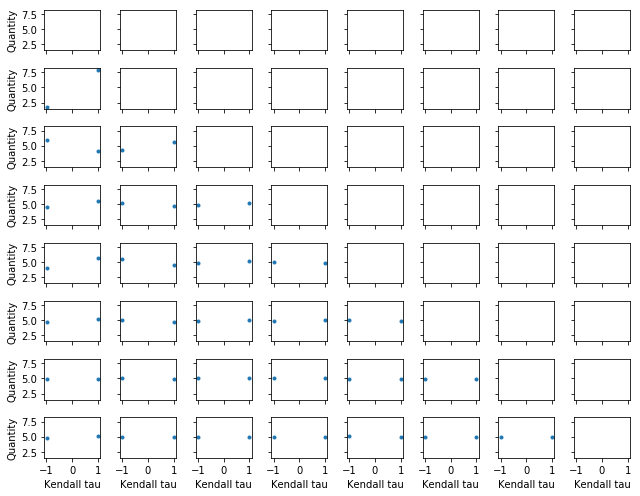

In [38]:
matrix_plot_results(iterative_results[0])